## Aggregated F1 Race Data for 2018

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np
import xgboost as xgb
import shap
from scipy.special import softmax
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline



race = pd.read_csv('race_agg2.csv')

pd.set_option('display.max_columns', None)


In [2]:
label_encoder = LabelEncoder()

race['Status_encoded'] = label_encoder.fit_transform(race['Status'])

In [3]:
columns_to_drop = ['AverageLapTime', 'AverageSector1Time', 'AverageSector2Time', 'AverageSector3Time', 'AverageSector1SessionTime', 'AverageSector2SessionTime', 'AverageSector3SessionTime']
race = race.drop(columns=columns_to_drop)

In [4]:
race.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 59 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Status                          420 non-null    object 
 1   DriverNumber                    420 non-null    int64  
 2   raceId                          420 non-null    object 
 3   Entire Race Braking Percentage  420 non-null    float64
 4   Average Throttle Percentage     420 non-null    float64
 5   Most Used Gear                  420 non-null    int64  
 6   DRS Percentage                  420 non-null    float64
 7   Average RPM                     417 non-null    float64
 8   FullName                        420 non-null    object 
 9   Position_results                420 non-null    int64  
 10  ClassifiedPosition              420 non-null    object 
 11  GridPosition                    420 non-null    int64  
 12  Time_results                    420 

# Safety Analysis: Accidents and Collisions

# Random Forest Classifier

In [5]:
# Define features X and target y
X = race.drop(['raceId','FullName','ClassifiedPosition', 'accident_collision','Position_results','Podium','Points','Time_results','Status','Status_encoded'
], axis=1)
y = race['accident_collision']

# Get feature names before any transformations
feature_names = X.columns.tolist()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize the imputer
imputer = SimpleImputer(strategy='mean') 


# Fit and transform the training data
X_train = imputer.fit_transform(X_train)

# Transform the test data
X_test = imputer.transform(X_test)

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    min_samples_split=10, 
    min_samples_leaf=4, 
    random_state=42,
    bootstrap=True, 
    max_features='sqrt'  
)

# Train the model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.97      0.99      0.98       161
           1       0.67      0.29      0.40         7

    accuracy                           0.96       168
   macro avg       0.82      0.64      0.69       168
weighted avg       0.96      0.96      0.96       168



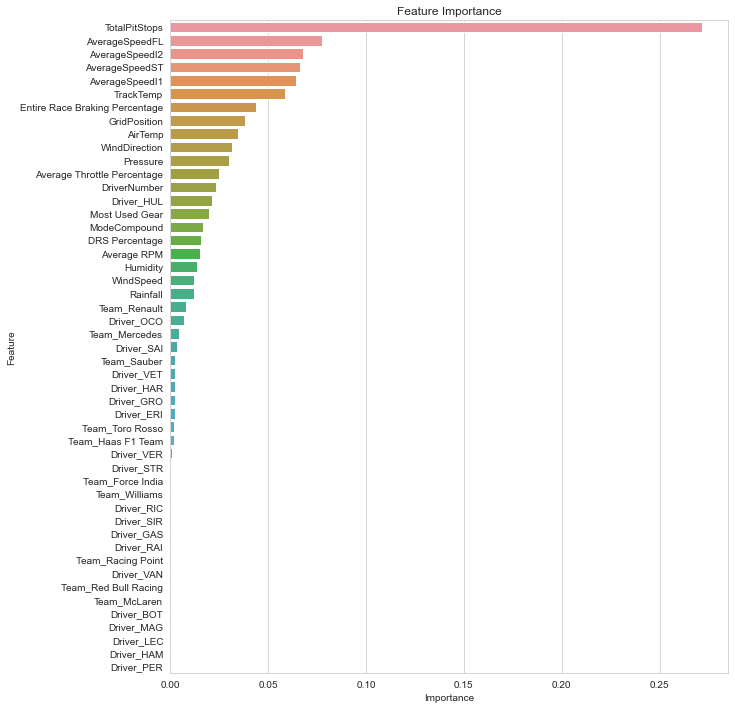

In [6]:
feature_importances = clf.feature_importances_

# Create a DataFrame to view the feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 12))

# Create a bar plot of feature importances
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)

# Set the title and labels
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Show the plot
plt.show()

# XGBoost Model

In [7]:
# Define features X and target y
X = race.drop(['raceId','FullName','ClassifiedPosition', 'accident_collision','Position_results','Podium','Points','Time_results','Status','Status_encoded'
], axis=1)
y = race['accident_collision']

# Get feature names before any transformations
feature_names = X.columns.tolist()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize the imputer
imputer = SimpleImputer(strategy='mean') 

# Fit and transform the training data
X_train = imputer.fit_transform(X_train)

# Transform the test data
X_test = imputer.transform(X_test)

In [8]:
# Initialize the XGBoost Classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       161
           1       0.60      0.43      0.50         7

    accuracy                           0.96       168
   macro avg       0.79      0.71      0.74       168
weighted avg       0.96      0.96      0.96       168



In [9]:
# Transform the test data
X_test = imputer.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Explain the model's predictions using SHAP values
explainer = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

X does not have valid feature names, but SimpleImputer was fitted with feature names
[10:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [10]:
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

        
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_test)

print_feature_importances_shap_values(shap_values, feature_names)
      

TotalPitStops -> 0.8003 (softmax = 0.0392)
Average Throttle Percentage -> 0.7326 (softmax = 0.0366)
AverageSpeedI2 -> 0.7047 (softmax = 0.0356)
AverageSpeedFL -> 0.5584 (softmax = 0.0308)
AverageSpeedI1 -> 0.4592 (softmax = 0.0279)
DRS Percentage -> 0.3548 (softmax = 0.0251)
GridPosition -> 0.3335 (softmax = 0.0246)
WindSpeed -> 0.2967 (softmax = 0.0237)
AverageSpeedST -> 0.2897 (softmax = 0.0235)
Average RPM -> 0.2600 (softmax = 0.0228)
WindDirection -> 0.2253 (softmax = 0.0221)
ModeCompound -> 0.2126 (softmax = 0.0218)
Pressure -> 0.1643 (softmax = 0.0207)
TrackTemp -> 0.1449 (softmax = 0.0203)
AirTemp -> 0.1193 (softmax = 0.0198)
Humidity -> 0.1144 (softmax = 0.0197)
Entire Race Braking Percentage -> 0.0764 (softmax = 0.0190)
Most Used Gear -> 0.0752 (softmax = 0.0190)
DriverNumber -> 0.0673 (softmax = 0.0188)
Driver_ERI -> 0.0223 (softmax = 0.0180)
Driver_VER -> 0.0207 (softmax = 0.0180)
Rainfall -> 0.0000 (softmax = 0.0176)
Driver_BOT -> 0.0000 (softmax = 0.0176)
Driver_GAS -> 0.0

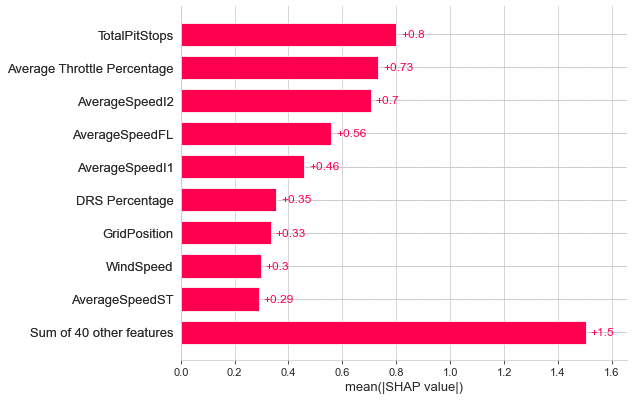

In [11]:
shap.plots.bar(shap_values)

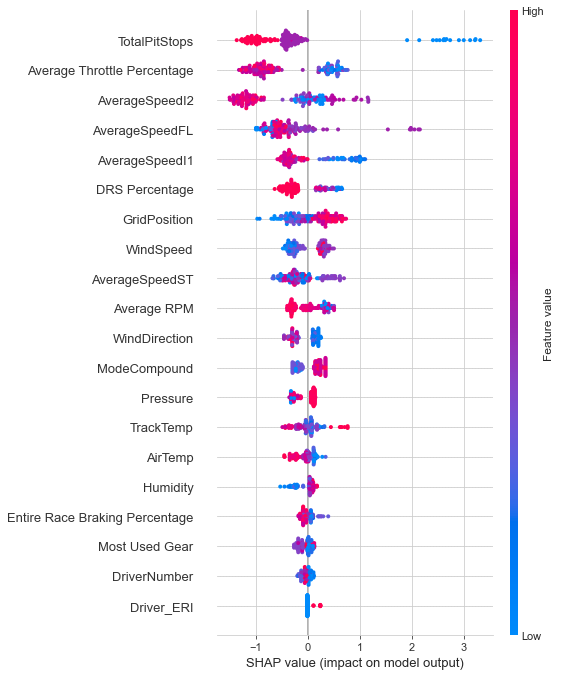

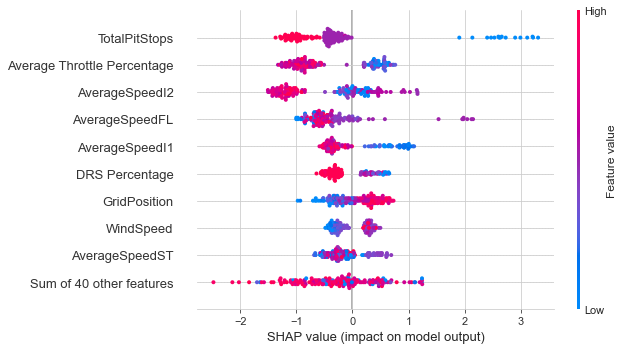

In [12]:
shap.summary_plot(shap_values)
# or 
shap.plots.beeswarm(shap_values)

# Clustering

In [13]:
scaler = StandardScaler()
race_scaled = scaler.fit_transform(race.select_dtypes(include=[np.number]))
X_train, X_test = train_test_split(race_scaled, test_size=0.2, random_state=42)
X = race[['Status_encoded']]

### Elbow Method

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than

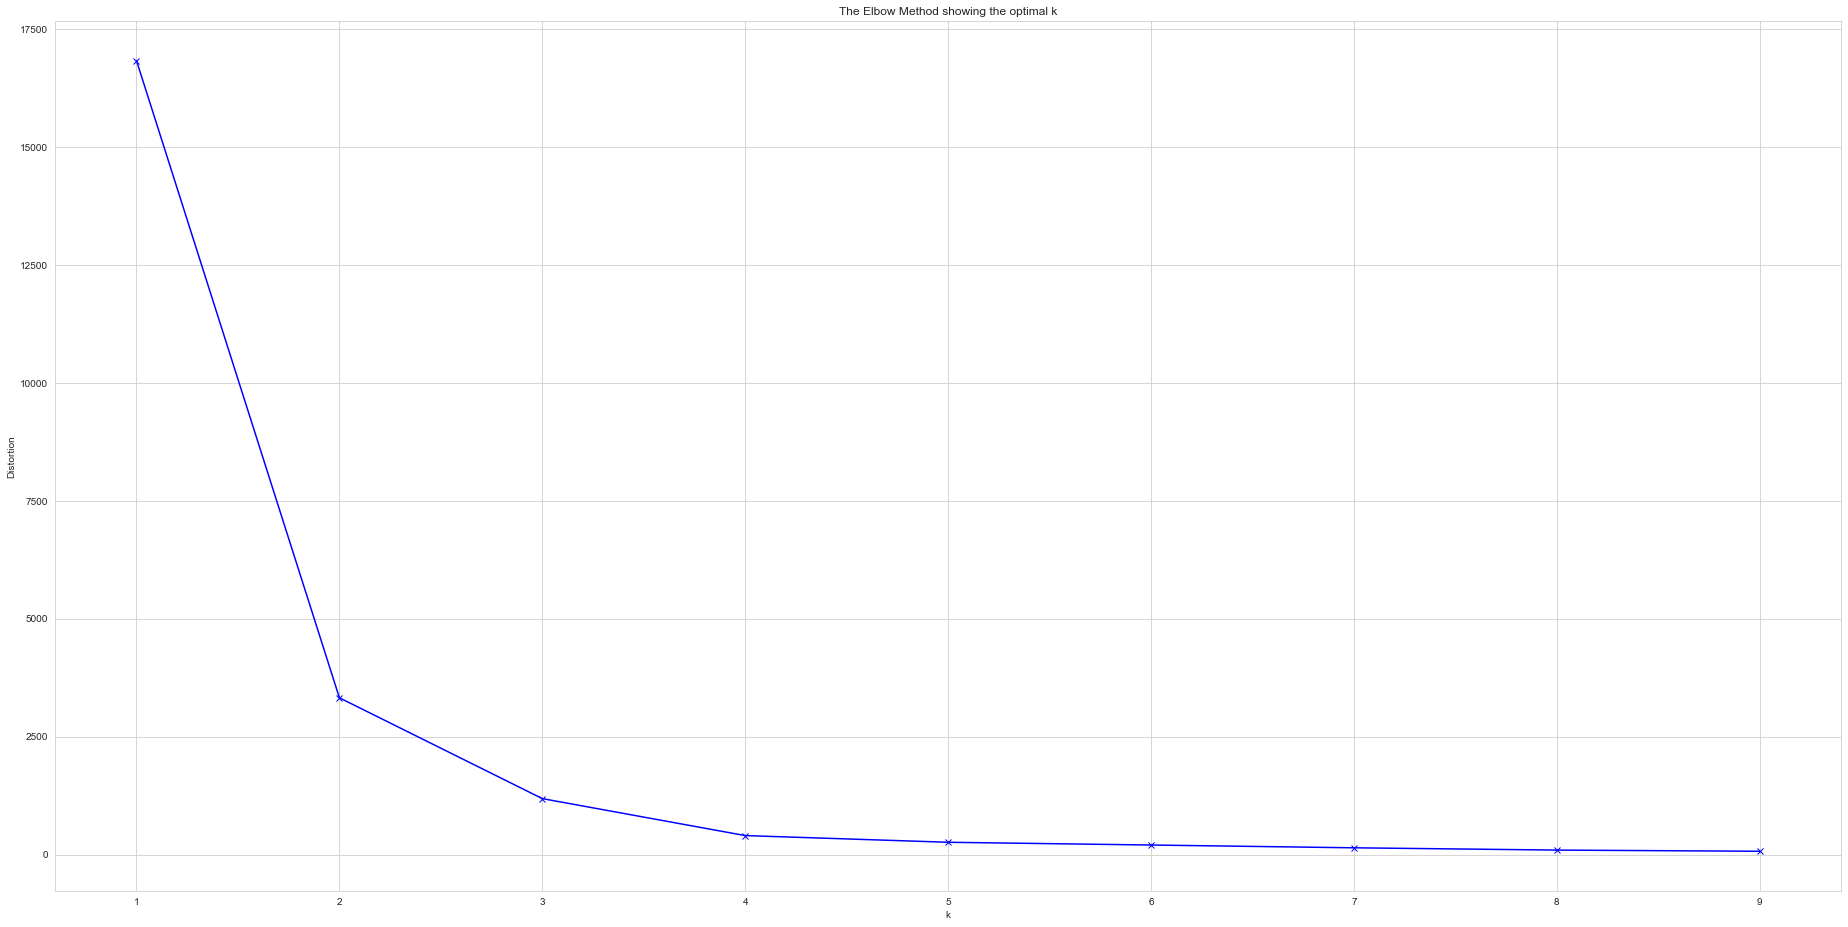

In [14]:
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)  
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(32, 16))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [15]:
# Choosing 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
race['Cluster'] = kmeans.labels_

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


In [16]:
from sklearn.metrics import silhouette_score

# Now, compute the silhouette coefficients:
sil_coeff = silhouette_score(X, kmeans.labels_, metric='euclidean')

print("The Silhouette Coefficient is:", sil_coeff)

The Silhouette Coefficient is: 0.8461583017481527


In [17]:
print(race.groupby('Cluster')['Status'].value_counts())
for cluster in range(3):
    cluster_data = race[race['Cluster'] == cluster]
    mode_status = cluster_data['Status'].mode()
    if not mode_status.empty:
        mode_status = mode_status.iloc[0]
    else:
        mode_status = "No mode found"
    print(f"Cluster {cluster} Status Mode:", mode_status)

Cluster  Status          
0        +1 Lap              109
         +2 Laps              33
         Collision            19
         Accident              7
         Brakes                7
         +3 Laps               2
         Battery               1
1        Finished            191
         Engine               13
         Collision damage      5
         Disqualified          3
         Gearbox               3
         Exhaust               2
         Hydraulics            2
         Electrical            1
         Fuel pressure         1
         Mechanical            1
         Oil leak              1
2        Wheel                 4
         Power loss            3
         Puncture              3
         Retired               2
         Suspension            2
         Overheating           1
         Power Unit            1
         Steering              1
         Turbo                 1
         Tyre                  1
Name: Status, dtype: int64
Cluster 0 Status Mode: 

In [18]:
for cluster in range(3):
    cluster_data = race[race['Cluster'] == cluster]
    
    # Print mode of 'Status' for the current cluster
    mode_status = cluster_data['Status'].mode()
    if not mode_status.empty:
        mode_status = mode_status.iloc[0]
    else:
        mode_status = "No mode found"
    print(f"\nCluster {cluster} Status Mode:", mode_status)
    
    # Get and print descriptive statistics for 'Status' in the current cluster
    status_description = cluster_data.describe()
    print(f"Descriptive statistics for 'Status' in Cluster {cluster}:\n{status_description}")
    status_description.to_csv(f'cluster_{cluster}_description.csv', index=True)



Cluster 0 Status Mode: +1 Lap
Descriptive statistics for 'Status' in Cluster 0:
       DriverNumber  Entire Race Braking Percentage  \
count    178.000000                      178.000000   
mean      20.550562                       28.643492   
std       14.094525                        7.989305   
min        2.000000                        0.000000   
25%        9.250000                       23.665455   
50%       18.000000                       29.371085   
75%       28.000000                       33.723649   
max       77.000000                       49.245053   

       Average Throttle Percentage  Most Used Gear  DRS Percentage  \
count                   178.000000      178.000000      178.000000   
mean                     67.844580        3.719101       93.022497   
std                      14.983191        1.499444       14.020260   
min                       0.000000        1.000000       11.751859   
25%                      60.099029        3.000000       91.379156   
50%


Cluster 2 Status Mode: Wheel
Descriptive statistics for 'Status' in Cluster 2:
       DriverNumber  Entire Race Braking Percentage  \
count     19.000000                       19.000000   
mean      21.105263                       25.915487   
std       18.546922                        9.706441   
min        3.000000                        0.000000   
25%        8.500000                       21.735047   
50%       16.000000                       24.163312   
75%       27.500000                       33.660874   
max       77.000000                       40.051835   

       Average Throttle Percentage  Most Used Gear  DRS Percentage  \
count                    19.000000       19.000000       19.000000   
mean                     64.061129        4.105263       89.443466   
std                      20.736710        1.663154       20.034718   
min                       0.000000        2.000000       21.875491   
25%                      53.864630        3.000000       88.461666   
50% 

# Performance Analysis

In [19]:
# Define features X and target y
X = race.drop(['raceId','FullName','ClassifiedPosition','Position_results','Podium','Points','Time_results','Status'
], axis=1)
y = race['Podium']

# Get feature names before any transformations
feature_names = X.columns.tolist()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize the imputer
imputer = SimpleImputer(strategy='mean') 

# Fit and transform the training data
X_train = imputer.fit_transform(X_train)

# Transform the test data
X_test = imputer.transform(X_test)

In [20]:
# Initialize the XGBoost Classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       149
           1       0.60      0.63      0.62        19

    accuracy                           0.91       168
   macro avg       0.78      0.79      0.78       168
weighted avg       0.91      0.91      0.91       168



In [21]:
# Transform the test data
X_test = imputer.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Explain the model's predictions using SHAP values
explainer = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

X does not have valid feature names, but SimpleImputer was fitted with feature names
[10:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [22]:
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_test)

print_feature_importances_shap_values(shap_values, feature_names)

GridPosition -> 1.8720 (softmax = 0.0988)
Status_encoded -> 1.3240 (softmax = 0.0571)
Average RPM -> 0.5709 (softmax = 0.0269)
Average Throttle Percentage -> 0.5273 (softmax = 0.0257)
DriverNumber -> 0.4622 (softmax = 0.0241)
AverageSpeedI1 -> 0.3635 (softmax = 0.0219)
AverageSpeedFL -> 0.3447 (softmax = 0.0214)
AverageSpeedST -> 0.2952 (softmax = 0.0204)
WindSpeed -> 0.2595 (softmax = 0.0197)
DRS Percentage -> 0.2395 (softmax = 0.0193)
Entire Race Braking Percentage -> 0.2394 (softmax = 0.0193)
TrackTemp -> 0.2172 (softmax = 0.0189)
Driver_VER -> 0.1433 (softmax = 0.0175)
Pressure -> 0.1376 (softmax = 0.0174)
AverageSpeedI2 -> 0.1060 (softmax = 0.0169)
Rainfall -> 0.1028 (softmax = 0.0168)
TotalPitStops -> 0.0899 (softmax = 0.0166)
Humidity -> 0.0871 (softmax = 0.0166)
Driver_RAI -> 0.0821 (softmax = 0.0165)
AirTemp -> 0.0775 (softmax = 0.0164)
ModeCompound -> 0.0643 (softmax = 0.0162)
Driver_HAM -> 0.0614 (softmax = 0.0162)
Driver_VET -> 0.0569 (softmax = 0.0161)
Most Used Gear -> 0.

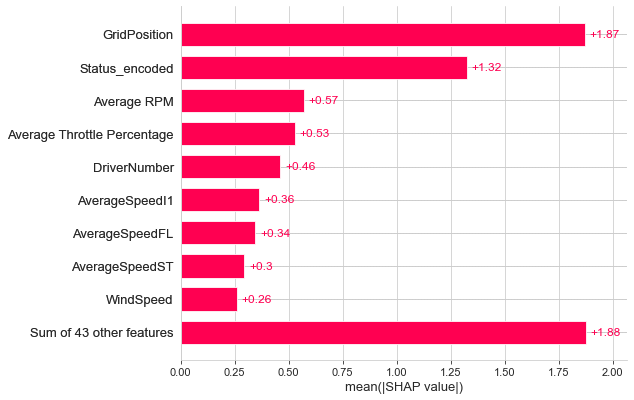

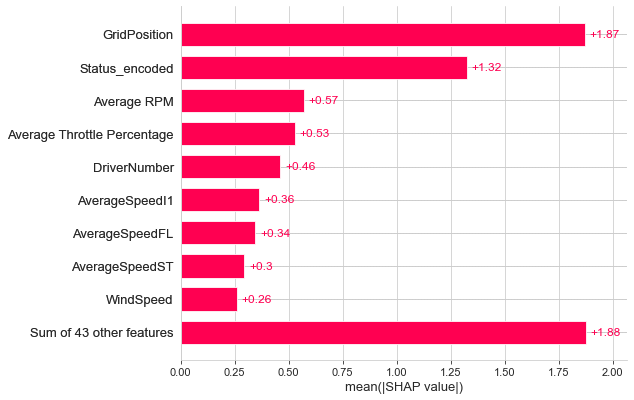

In [23]:
shap.plots.bar(shap_values)
shap.plots.bar(shap_values)

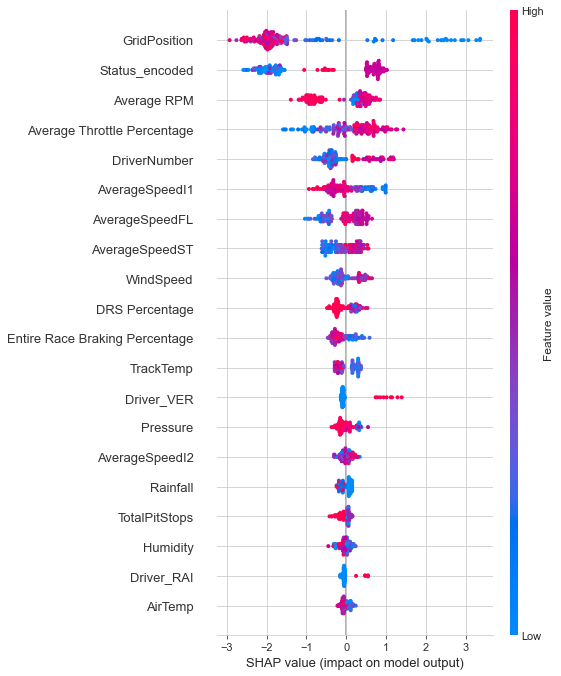

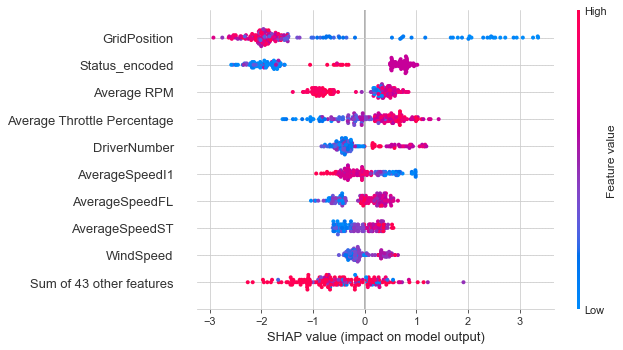

In [24]:
shap.summary_plot(shap_values)
# or 
shap.plots.beeswarm(shap_values)

# Random Forest

In [25]:
# Define features X and target y
X = race.drop(['raceId','FullName','ClassifiedPosition','Position_results','Podium','Points','Time_results','Status'
], axis=1)
y = race['Podium']

# Get feature names before any transformations
feature_names = X.columns.tolist()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize the imputer
imputer = SimpleImputer(strategy='mean') 


# Fit and transform the training data
X_train = imputer.fit_transform(X_train)

# Transform the test data
X_test = imputer.transform(X_test)

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    min_samples_split=10, 
    min_samples_leaf=4, 
    random_state=42,
    bootstrap=True, 
    max_features='sqrt'  
)

# Train the model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.94      0.98      0.96       149
           1       0.75      0.47      0.58        19

    accuracy                           0.92       168
   macro avg       0.84      0.73      0.77       168
weighted avg       0.91      0.92      0.91       168



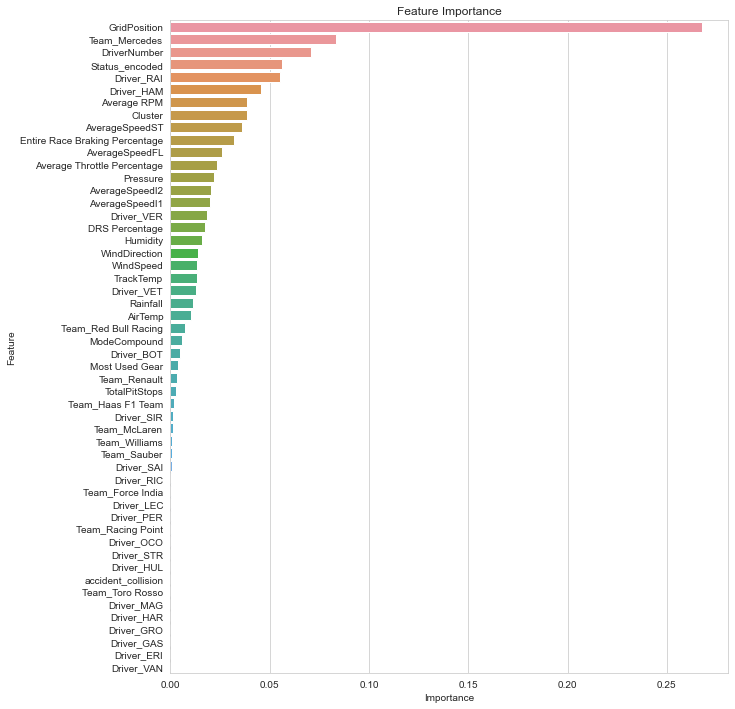

In [26]:
feature_importances = clf.feature_importances_

# Create a DataFrame to view the feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 12))

# Create a bar plot of feature importances
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)

# Set the title and labels
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Show the plot
plt.show()

In [27]:
race.head(40)

,Status,DriverNumber,raceId,Entire Race Braking Percentage,Average Throttle Percentage,Most Used Gear,DRS Percentage,Average RPM,FullName,Position_results,ClassifiedPosition,GridPosition,Time_results,Points,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Driver_BOT,Driver_ERI,Driver_GAS,Driver_GRO,Driver_HAM,Driver_HAR,Driver_HUL,Driver_LEC,Driver_MAG,Driver_OCO,Driver_PER,Driver_RAI,Driver_RIC,Driver_SAI,Driver_SIR,Driver_STR,Driver_VAN,Driver_VER,Driver_VET,Team_Force India,Team_Haas F1 Team,Team_McLaren,Team_Mercedes,Team_Racing Point,Team_Red Bull Racing,Team_Renault,Team_Sauber,Team_Toro Rosso,Team_Williams,TotalPitStops,Podium,accident_collision,AverageSpeedI1,AverageSpeedI2,AverageSpeedFL,AverageSpeedST,ModeCompound,Status_encoded,Cluster
0,Finished,44,2018r1r,27.356615,71.707265,5,83.232220,8915.067276,Lewis Hamilton,2,2,1,5.036000e+00,18,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2.0,1,0,256.076923,283.206897,276.140351,275.368421,4,12,1
1,Finished,7,2018r1r,21.312771,59.204945,7,88.422126,8521.064244,Kimi Räikkönen,3,3,2,6.309000e+00,15,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1,0,262.240000,282.245614,275.280702,269.680000,4,12,1
2,Finished,5,2018r1r,22.533775,60.615651,5,80.922763,9040.355150,Sebastian Vettel,1,1,3,5.373283e+03,25,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2.0,1,0,263.173077,282.706897,274.877193,277.596154,4,12,1
3,Finished,33,2018r1r,20.303339,56.340352,3,85.449911,9122.732879,Max Verstappen,6,6,4,2.894500e+01,8,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2.0,0,0,262.352941,284.948276,283.929825,285.018519,4,12,1
4,Finished,3,2018r1r,20.994137,58.082182,4,88.432322,9024.565183,Daniel Ricciardo,4,4,8,7.069000e+00,12,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.0,0,0,263.865385,282.258621,285.140351,279.333333,4,12,1
5,Wheel,20,2018r1r,31.170023,78.457966,7,99.847056,8167.501348,Kevin Magnussen,17,R,5,-9.223372e+09,0,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0,0,265.833333,285.272727,280.523810,277.777778,6,27,2
6,Wheel,8,2018r1r,32.003569,78.429977,6,100.000000,8344.804701,Romain Grosjean,16,R,6,-9.223372e+09,0,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0,0,270.619048,290.333333,284.521739,281.681818,6,27,2
7,Finished,27,2018r1r,23.464186,60.593372,4,100.000000,9055.395015,Nico Hulkenberg,7,7,7,3.267100e+01,6,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.0,0,0,263.294118,283.913793,280.175439,280.711539,4,12,1
8,Finished,55,2018r1r,19.222534,52.601886,6,84.700484,9175.068858,Carlos Sainz,10,10,9,4.572200e+01,1,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.0,0,0,259.319149,280.017241,275.982456,268.298246,4,12,1
9,Finished,77,2018r1r,26.143258,65.576447,5,88.427224,9061.538144,Valtteri Bottas,8,8,15,3.433900e+01,4,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2.0,0,0,261.946429,286.379310,286.421053,281.490909,5,12,1
